In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
import diffrax
import matplotlib.pyplot as plt
%matplotlib widget

jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_disable_jit", True)

from pylinger_background import evolve_background
from pylinger_perturbations import evolve_one_mode, evolve_perturbations

In [2]:
## Cosmological Parameters
Tcmb = 2.7255
YHe = 0.248
Omegam = 0.276
Omegab = 0.0455
OmegaL = 1.0-Omegam
num_massive_neutrinos = 1
mnu=0.06 #eV
Neff=2.046 # -1 if massive neutrino present
standard_neutrino_neff=Neff+num_massive_neutrinos
H0 = 70.3
A_s = 2.1e-9
n_s = 0.965
k_p = 0.05

In [3]:
cosmo_param_names = ['\\Omega_{m}','\\Omega_{b}','A_s','n_s','H_0','T_{CMB}','Y_{He}','N_{eff}','m_{\\nu}']
fiducial_cosmo_param = [Omegam,Omegab,A_s,n_s,H0,Tcmb,YHe,Neff,mnu]

# @eqx.filter_jit
def f_of_Omegam( args ):
    """
    args:
        0: Omegam
        1: Omegab
        2: A_s
        3: n_s
        4: H0
        5: Tcmb
        6: YHe
        7: Neff
        8: mnu
    """
    A_s = args[2]
    n_s = args[3]
    param = {}
    param['Omegam'] = args[0]
    param['Omegab'] = args[1]
    param['OmegaL'] = 1-param['Omegam']
    param['Omegak'] = 0.0
    param['A_s'] = args[2]
    param['n_s'] = args[3]
    param['H0'] = args[4]
    param['Tcmb'] = args[5]
    param['YHe'] = args[6]
    param['Neff'] = args[7]
    param['Nmnu'] = 1
    param['mnu'] = args[8]
    param = evolve_background(param=param)
    
    k = 1e-2

    # Compute Perturbations
    lmaxg  = 12
    lmaxgp = 12
    lmaxr  = 17
    lmaxnu = 17
    nqmax  = 15

    rtol   = 1e-3
    atol   = 1e-4

    # Compute Perturbations
    nmodes = 128
    kmin = 1e-5
    kmax = 1e1
    # aexp_out = jnp.array([1e-2,1e-1]) 
    aexp_out = jnp.geomspace(1e-2,1,2)

    y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out )

    k=kmodes[:,None,None]
    return A_s*(k/k_p)**(n_s - 1) * k**(-3) * y**2 

In [4]:

# @eqx.filter_jit
def fonek_of_Omegam( args, kmode ):
    """
    args:
        0: Omegam
        1: Omegab
        2: A_s
        3: n_s
        4: H0
        5: Tcmb
        6: YHe
        7: Neff
        8: mnu
    """
    A_s = args[2]
    n_s = args[3]
    param = {}
    param['Omegam'] = args[0]
    param['Omegab'] = args[1]
    param['OmegaL'] = 1-param['Omegam']
    param['Omegak'] = 0.0
    param['A_s'] = args[2]
    param['n_s'] = args[3]
    param['H0'] = args[4]
    param['Tcmb'] = args[5]
    param['YHe'] = args[6]
    param['Neff'] = args[7]
    param['Nmnu'] = 1
    param['mnu'] = args[8]
    param = evolve_background(param=param)
    
    k = 1e-2

    # Compute Perturbations
    lmaxg  = 12
    lmaxgp = 12
    lmaxr  = 17
    lmaxnu = 17
    nqmax  = 15

    rtol   = 1e-3
    atol   = 1e-4

    # Compute Perturbations
    nmodes = 128
    kmin = 1e-5
    kmax = 1e1
    # aexp_out = jnp.array([1e-2,1e-1]) 
    aexp_out = jnp.geomspace(1e-5,1,128)
    tau_out = jax.vmap( lambda a: param['tau_of_a_spline'].evaluate(a) )(aexp_out)

    y = evolve_one_mode( param=param, kmode=kmode, tau_out=tau_out, tau_max=jnp.max(tau_out) )

    k = kmode
    return A_s*(k/k_p)**(n_s - 1) * k**(-3) * y**2 

In [5]:
## compute the jacobian at few times, but for many k
k  = jnp.geomspace(1e-2,1e1,128)
dy = jax.jacfwd(f_of_Omegam)(fiducial_cosmo_param)

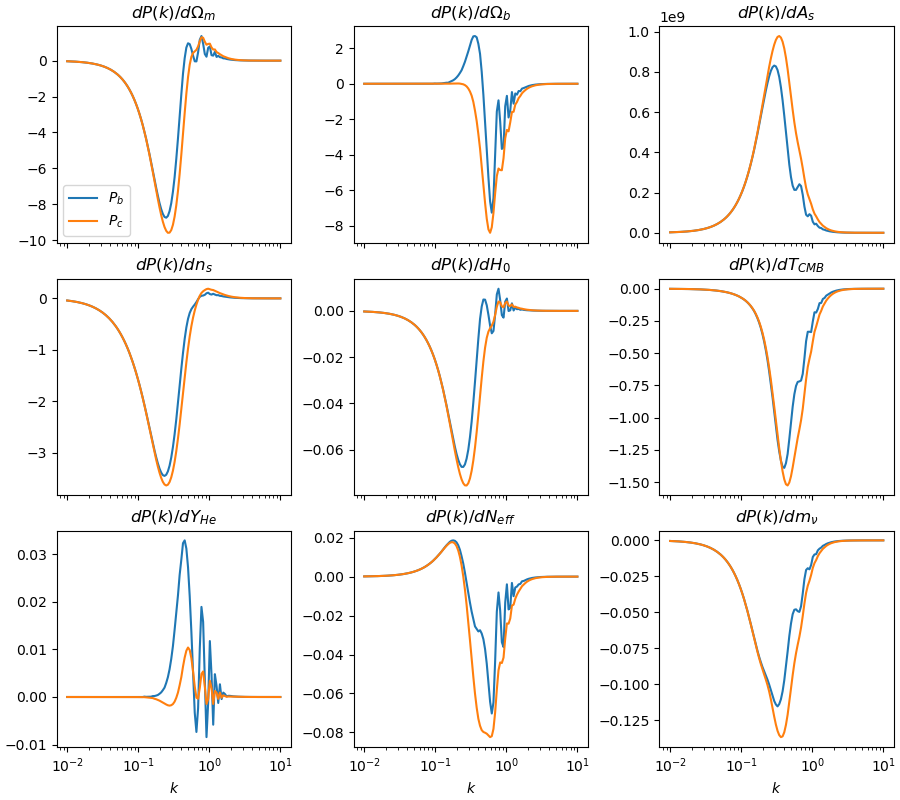

In [25]:
fig,ax = plt.subplots(3,3,sharex=True,figsize=(9,8),layout='constrained')
for i in range(3):
    for j in range(3):
        ax[i,j].semilogx(k, dy[3*i+j][:,0,5],label='$P_b$')
        ax[i,j].semilogx(k, dy[3*i+j][:,0,3],label='$P_c$')
        ax[i,j].set_title(f'$d P(k) / d{cosmo_param_names[3*i+j]}$')
              
ax[0,0].legend()

for i in range(3):
    ax[2,i].set_xlabel('$k$')

plt.savefig('diff_Pk.pdf',bbox_inches='tight')


In [ ]:
## compute the Jacobian for one k, but for many times
kk = 1e-2
aexp_out = jnp.geomspace(1e-5,1,128)
dyonek = jax.jacfwd(fonek_of_Omegam)(fiducial_cosmo_param,kk)

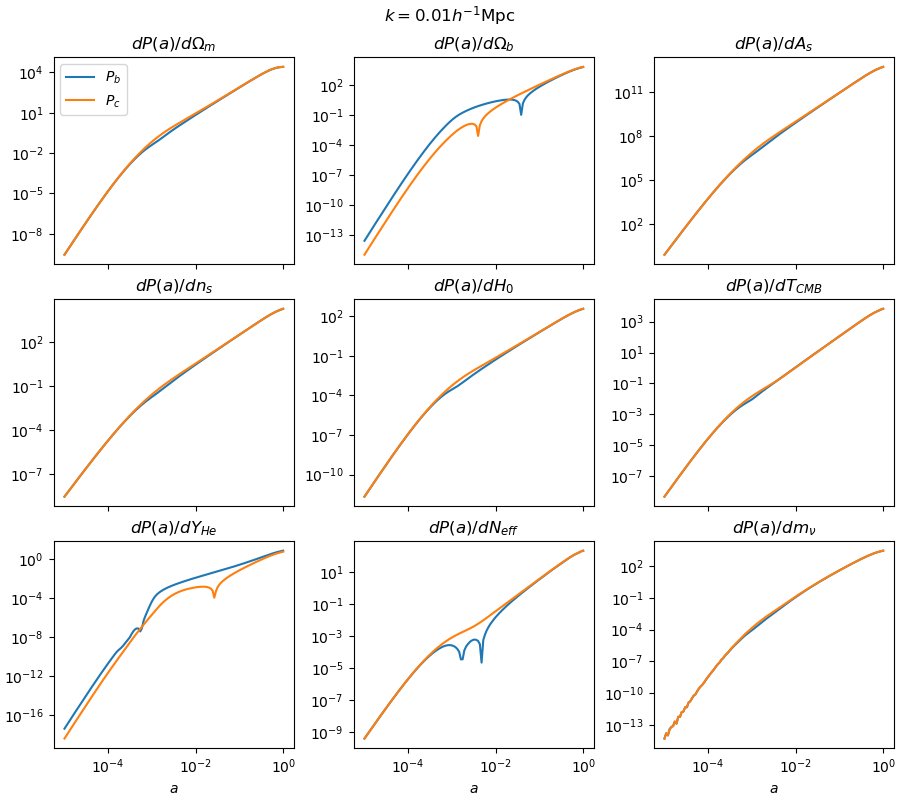

In [27]:
fig,ax = plt.subplots(3,3,sharex=True,figsize=(9,8),layout='constrained')
for i in range(3):
    for j in range(3):
        ax[i,j].loglog( aexp_out, np.abs(dyonek[3*i+j][:,5]),label='$P_b$')
        ax[i,j].loglog( aexp_out, np.abs(dyonek[3*i+j][:,3]),label='$P_c$')
        ax[i,j].set_title(f'$d P(a) / d{cosmo_param_names[3*i+j]}$')

ax[0,0].legend()

for i in range(3):
    ax[2,i].set_xlabel('$a$')

fig.suptitle(f'$k = {kk} h^{{-1}}{{\\rm Mpc}}$')

plt.savefig('diff_Pa.pdf',bbox_inches='tight')